
##**Unfinished!!!**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("GPU not available.")

GPU is available: Tesla T4


In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available:", tf.config.list_physical_devices('GPU'))
else:
    print("GPU not available.")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Ensure tensor operations are in GPU VRAM
device = torch.device("cuda")  # Specify the GPU
data = torch.randn(1000, 1000).to(device)  # Data directly allocated in GPU memory
result = torch.matmul(data, data.T)  # Computations occur in GPU
print(result.device)  # Output: 'cuda:0'

cuda:0


# ***⊹₊ ˚‧︵‿₊ 𝟏. 𝐈𝐦𝐩𝐥𝐞𝐦𝐞𝐧𝐭 𝐑𝐞𝐬𝐢𝐝𝐮𝐚𝐥 𝐁𝐥𝐨𝐜𝐤𝐬 ₊‿︵‧ ˚ ₊⊹***

In [ ]:
# Chapter 10: Slide 94: a)

# Input (X) ----> BN1 ----> ReLU ----> Conv1 ----> BN2 ----> ReLU ----> Conv2 --------> Output
#        |                                                                        |
#        |---------------- Skip Connection (Identity or -x- Conv) ----------------|

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First Convolutional Layer:
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)

        # Second Convolutional Layer:
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # ReLU Activation Function:
        self.relu = nn.ReLU(inplace=True)


    # Implementing Skip Connection:
    def forward(self, x):
        identity = x  # Save the input for the skip connection

        # Forward pass through the First layer:
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        # Forward pass through the Second layer:
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        # Add the skip connection
        out += identity

        return out

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First layer: BN -> ReLU -> Conv
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        # Second layer: BN -> ReLU -> Conv
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # Optional downsampling for skip connection
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        # First layer
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        # Second layer
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        return out


# ***⊹₊ ˚‧︵‿₊ 𝟐. 𝐁𝐮𝐢𝐥𝐝 𝐑𝐞𝐬𝐍𝐞𝐭 𝐀𝐫𝐜𝐡𝐢𝐭𝐞𝐜𝐭𝐮𝐫𝐞 ₊‿︵‧ ˚ ₊⊹***

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        # Initial convolutional layer: BN -> ReLU -> Conv
        self.initial_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Stages with residual blocks
        self.stage1 = self._make_stage(64, 64, num_blocks=2, stride=1)
        self.stage2 = self._make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self._make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self._make_stage(256, 512, num_blocks=2, stride=2)

        # Global average pooling and fully connected layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        # First block in the stage handles stride
        layers.append(ResidualBlock(in_channels, out_channels, stride))

        # Remaining blocks
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ***⊹₊ ˚‧︵‿₊ 𝟑. 𝐓𝐫𝐚𝐢𝐧 𝐚𝐧𝐝 𝐄𝐯𝐚𝐥𝐮𝐚𝐭𝐞 𝐘𝐨𝐮𝐫 𝐌𝐨𝐝𝐞𝐥 ₊‿︵‧ ˚ ₊⊹***

In [ ]:
# Define transformations for the training and validation sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data ', train=True, download=True, transform=transform_train)

# Split the dataset into training (70%) and validation (30%) sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [ ]:
batch_size = 4
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


#Set Up the Model, Loss Function, and Optimizer

In [ ]:
# Create an instance of the ResNet model
model = ResNet18(num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#we can use SGD insted of Adam
#optimizer = optim.SGD(resNet.parameters(), lr=0.001, momentum=0.9)

#Train the Model

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    return train_losses, train_accuracies

# Train the model
num_epochs = 10
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 1.5885, Accuracy: 0.4217
Epoch [2/10], Loss: 1.2462, Accuracy: 0.5564
Epoch [3/10], Loss: 1.0842, Accuracy: 0.6163
Epoch [4/10], Loss: 0.9792, Accuracy: 0.6566
Epoch [5/10], Loss: 0.8981, Accuracy: 0.6840
Epoch [6/10], Loss: 0.8340, Accuracy: 0.7129
Epoch [7/10], Loss: 0.7789, Accuracy: 0.7292
Epoch [8/10], Loss: 0.7421, Accuracy: 0.7420
Epoch [9/10], Loss: 0.7014, Accuracy: 0.7571
Epoch [10/10], Loss: 0.6689, Accuracy: 0.7673


# Evaluate the Model

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model
evaluate_model(model, val_loader)

Validation Loss: 0.7042, Validation Accuracy: 0.7585


# Plot Training and Validation Loss and Accuracy

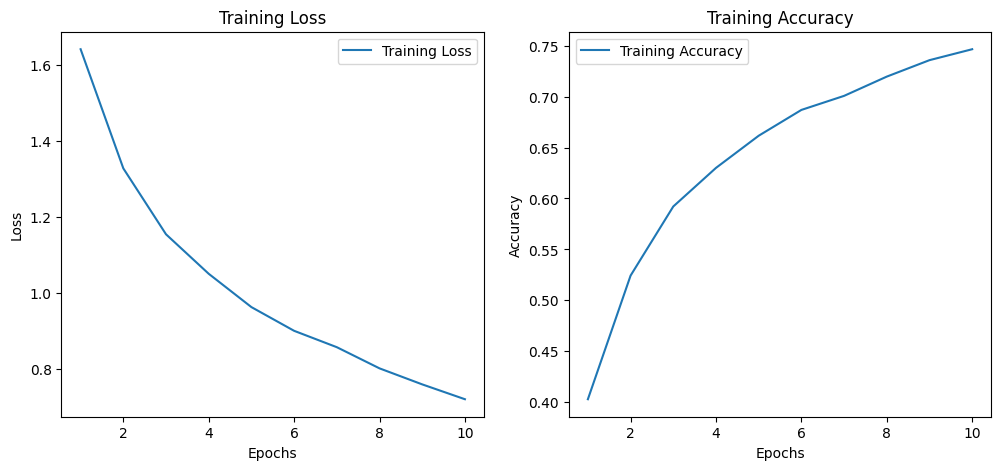

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

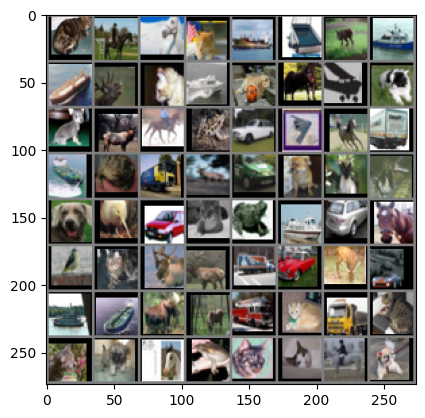

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# get some random training images
# Use train_loader instead of trainloader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# Assuming 'classes' and 'batch_size' are defined
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
outputs = model(images)

cat   horse horse cat   ship  truck deer  ship  ship  deer  cat   ship  dog   horse plane dog   dog   deer  horse frog  car   plane horse truck ship  frog  truck deer  car   dog   cat   dog   dog   bird  car   cat   frog  ship  car   horse bird  cat   deer  deer  truck car   deer  car   ship  ship  deer  deer  truck cat   truck cat   cat   dog   horse frog  cat   cat   horse dog  


In [ ]:
_, predicted = torch.max(outputs, 1)

# Change range(25) to range(predicted.size(0))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(0))))


Predicted:  dog   bird  frog  frog  frog  truck truck horse car   car   dog   car   dog   frog  car   car   car   frog  car   frog  truck car   dog   frog  frog  plane plane car   plane dog   frog  car   car   car   frog  dog   truck car   car   horse truck frog  dog   car   truck frog  dog   frog  frog  deer  car   plane car   frog  car   cat   frog  frog  car   deer  truck plane car   frog 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 8.7 %
Accuracy for class: car   is 35.6 %
Accuracy for class: bird  is 0.2 %
Accuracy for class: cat   is 1.7 %
Accuracy for class: deer  is 3.0 %
Accuracy for class: dog   is 8.3 %
Accuracy for class: frog  is 31.5 %
Accuracy for class: horse is 1.5 %
Accuracy for class: ship  is 1.2 %
Accuracy for class: truck is 15.9 %


#Training on GPU

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Data transformations and augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_size = int(0.3 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Training loop
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100.0 * correct / total)

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(100.0 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_acc[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

        scheduler.step()

    return train_losses, val_losses, train_acc, val_acc

# Instantiate and train ResNet-18
model = ResNet18()
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=20)